In [10]:
from importlib import reload
import flymovie as fm
import cnn_models
import cnn_models.siamese_cnn as cn
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
from fpdf import FPDF
import random
import pickle
from pathlib import Path
import scipy.spatial
import scipy.ndimage as ndi
import tensorflow as tf
from importlib import reload
import scipy.ndimage as ndi
from skimage.measure import regionprops
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
im = fm.read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 12/embryo17.czi', swapaxes=False)
fm.viewer(im, 5)

interactive(children=(Dropdown(description='Color', index=9, options=('Greens', 'inferno', 'gray', 'gray_r', '…

In [25]:
thresh = 25
nucs = []
sm = ndi.gaussian_filter(im, (2,5,5))
mask = np.where(sm >= thresh, 1, 0)
lmask, _ = ndi.label(mask)
regions = regionprops(lmask)
for n in range(0, len(regions)):
    centroid = [int(x) for x in regions[n].centroid]
    i, j = centroid[1:]
    start_i = i - 50
    end_i = i + 50
    start_j = j - 50
    end_j = j + 50
    if ((start_i >= 0) & (start_j >= 0) & (end_i <= lmask.shape[1]) & (end_j <= lmask.shape[2])):
        nucs.append(im[5:39, start_i:end_i, start_j:end_j])
        


In [27]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch/checkpoint_final_8epochs_easytomedium_plus_8x99.9'
base_cnn = cn.make_base_cnn_3d(image_shape=(34,100,100), nlayers=8)
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

2022-03-09 11:46:46.914845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
e = np.ndarray((0,256))
for nuc in nucs:
    nuc = np.expand_dims(nuc, axis=0)
    nuc_e = embedding(nuc).numpy()
    e = np.vstack([e, nuc_e])




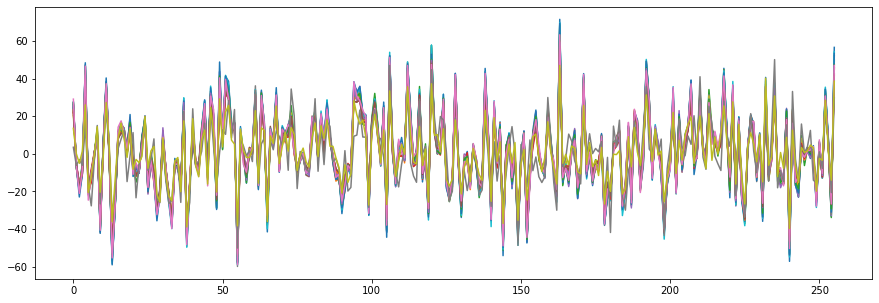

In [60]:
_ = plt.subplots(figsize=(15,5))
#sns.stripplot(data=e)
for e_ in e:
    plt.plot(e_)

<AxesSubplot:>

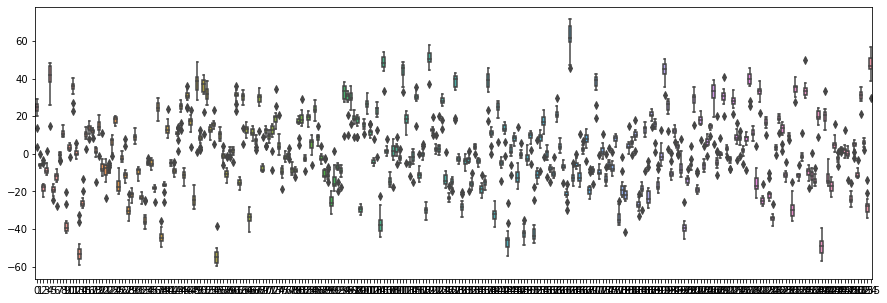

In [62]:
_ = plt.subplots(figsize=(15,5))
sns.boxplot(data=e)

In [ ]:
import sklearn.decomposition
def pca3d(e_base, e_test):
    combined = np.vstack((e_base, e_test))
    pca = sklearn.decomposition.PCA(n_components=3)
    pca.fit(combined)
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    tfm_base = pca.transform(e_base)
    ax.scatter(tfm_base[:,0], tfm_base[:,1], tfm_base[:,2], 
                    c="green")
    
    tfm_test = pca.transform(e_test)
    ax.scatter(tfm_test[:,0], tfm_test[:,1], tfm_test[:,2], 
                    c="red")

pca3d(embeddings_base, e)

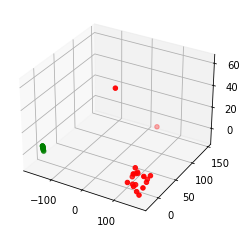

In [97]:
base_folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/siamese_eval_datasets/iso_HLB_fluors/left'
embeddings_base, params_base = ev.embed_images(base_folder, embedding)
pca3d(embeddings_base, e)

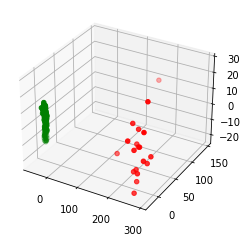

In [100]:
base_folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/siamese_eval_datasets/rpb1_wide_UTkaWAfT/left'
embeddings_base, params_base = ev.embed_images(base_folder, embedding)
pca3d(embeddings_base, e)

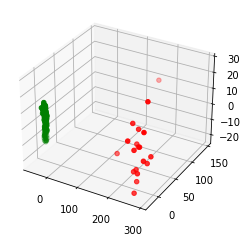

In [105]:
base_folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/siamese_eval_datasets/rpb1_wide_UTkaWAfT/left'
#embeddings_base, params_base = ev.embed_images(base_folder, embedding)
embeddings_base = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/test_embeddings.pkl')[0]
pca3d(embeddings_base, e)

In [90]:
scipy.spatial.distance.euclidean(embeddings_base[0], embeddings_base[4])

4.481123413509883

In [103]:
embeddings_base.shape

AttributeError: 'tuple' object has no attribute 'shape'